In [1]:
!pip install requests pandas matplotlib

In [ ]:

    
import requests
import pandas as pd
from datetime import datetime

API_TOKEN = "cfc8072c24493f9282708ddc6ce10ac043db8ec5"

def fetch_pm25_waqi(city="delhi"):
    """Fetch latest PM2.5 data for a given city using the WAQI API."""
    url = f"https://api.waqi.info/feed/{city}/?token={API_TOKEN}"
    r = requests.get(url)
    if r.status_code != 200:
        print("Error:", r.status_code, r.text)
        return None

    data = r.json()
    if data.get("status") != "ok":
        print("API Error:", data)
        return None

    iaqi = data["data"]["iaqi"]
    pm25 = iaqi.get("pm25", {}).get("v", None)
    time = data["data"]["time"]["s"]
    city_name = data["data"]["city"]["name"]

    df = pd.DataFrame([{
        "city": city_name,
        "pm25": pm25,
        "datetime": datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    }])

    return df
df_pm25 = fetch_pm25_waqi("delhi")
df_pm25







,city,pm25,datetime
0,"Major Dhyan Chand National Stadium, Delhi, Del...",284,2025-11-14


In [3]:
df_pm25 = fetch_pm25_waqi("delhi")
print(df_pm25)


                                                city  pm25   datetime
0  Major Dhyan Chand National Stadium, Delhi, Del...   284 2025-11-14


In [ ]:
import os
import csv
import time

def log_pm25_data(city="delhi", interval_minutes=30):
    """Fetch and log PM2.5 data every X minutes into a CSV file."""
    filename = f"{city.lower()}_pm25_log.csv"

    if not os.path.exists(filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["datetime", "city", "pm25"])

    while True:
        df = fetch_pm25_waqi(city)
        if df is not None and not df.empty:
            with open(filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(df.iloc[0][["datetime", "city", "pm25"]])
            print(f"✅ Logged: {df.iloc[0]['city']} | PM2.5: {df.iloc[0]['pm25']} | {df.iloc[0]['datetime']}")
        else:
            print("⚠️ Failed to fetch data. Skipping this round.")

        print(f"⏳ Waiting {interval_minutes} minutes before next reading...\n")
        time.sleep(interval_minutes * 60)


In [5]:
log_pm25_data("delhi", interval_minutes=1)


✅ Logged: Major Dhyan Chand National Stadium, Delhi, Delhi, India | PM2.5: 284 | 2025-11-14 00:00:00
⏳ Waiting 1 minutes before next reading...



KeyboardInterrupt: 

In [6]:
import pandas as pd
df = pd.read_csv("delhi_pm25_log.csv")
df.head()


,datetime,city,pm25
0,2025-11-13 23:00:00,"Major Dhyan Chand National Stadium, Delhi, Del...",283
1,2025-11-13 23:00:00,"Major Dhyan Chand National Stadium, Delhi, Del...",283
2,2025-11-13 23:00:00,"Major Dhyan Chand National Stadium, Delhi, Del...",283
3,2025-11-13 23:00:00,"Major Dhyan Chand National Stadium, Delhi, Del...",283
4,2025-11-14 00:00:00,"Major Dhyan Chand National Stadium, Delhi, Del...",284


In [7]:
pip install kaggle


In [8]:
!kaggle datasets list | findstr /R "^"



ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ayeshasiddiqa123/cars-pre                                       Car Price Analysis Dataset                               46557  2025-11-06 16:38:07.487000            965         32  1.0              
ayeshaimran123/social-media-and-mental-health-balance           Social Media and Mental Health Balance                    5941  2025-10-26 07:51:53.380000           4675         67  1.0              
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset        16151  2025-10-01 16:35:53.273000          19710        667  1.0              


In [9]:
!kaggle datasets download -d rohanrao/air-quality-data-in-india


Dataset URL: https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india
License(s): CC0-1.0




  0%|          | 0.00/72.9M [00:00<?, ?B/s]
 71%|#######1  | 52.0M/72.9M [00:00<00:00, 538MB/s]
100%|##########| 72.9M/72.9M [00:00<00:00, 530MB/s]


In [10]:
!mkdir air_quality
!tar -xf air-quality-data-in-india.zip -C air_quality


In [11]:
import pandas as pd

df = pd.read_csv("air_quality/city_day.csv")
df.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [12]:
df["PM2.5"].isna().sum(), df["PM2.5"].shape[0]


(np.int64(4598), 29531)

In [ ]:

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

df["PM2.5"] = df["PM2.5"].interpolate(method='linear')

print("Remaining NaN values:", df["PM2.5"].isna().sum())


Remaining NaN values: 2


In [14]:
df_delhi = df[df["City"] == "Delhi"].copy()
df_delhi["Date"] = pd.to_datetime(df_delhi["Date"])
df_delhi = df_delhi.sort_values("Date")

df_delhi.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [15]:
df_delhi["PM2.5"].isna().sum()


np.int64(0)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_delhi = df[df["City"] == "Delhi"].copy()
df_delhi["Date"] = pd.to_datetime(df_delhi["Date"])
df_delhi = df_delhi.sort_values("Date")

df_delhi.set_index("Date", inplace=True)

df_daily = df_delhi["PM2.5"].resample("D").mean()

df_daily.head()


Date
2015-01-01    313.22
2015-01-02    186.18
2015-01-03     87.18
2015-01-04    151.84
2015-01-05    146.60
Freq: D, Name: PM2.5, dtype: float64

In [17]:
stats = df_daily.describe()
print(stats)


count    2009.000000
mean      117.110893
std        82.916391
min        10.240000
25%        57.080000
50%        94.490000
75%       152.990000
max       685.360000
Name: PM2.5, dtype: float64


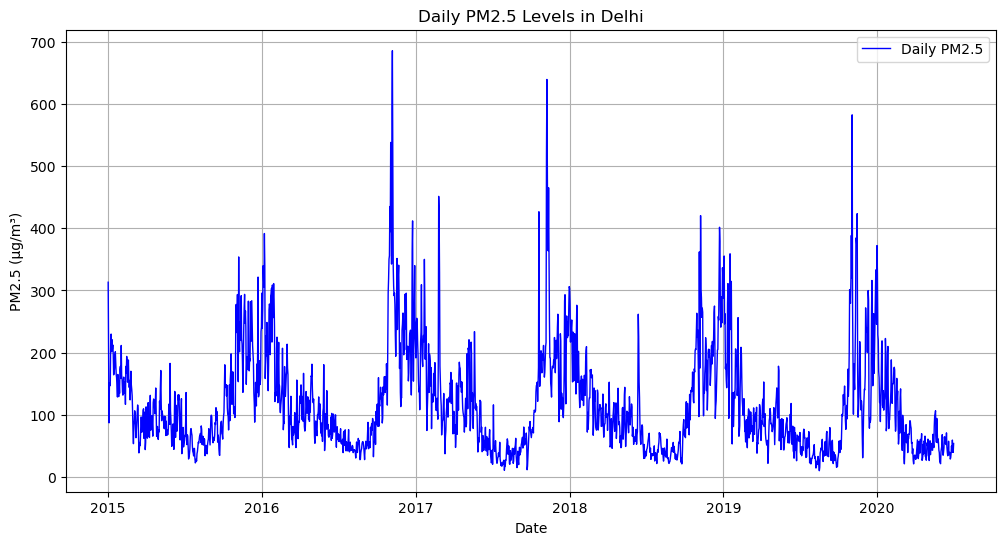

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily, label="Daily PM2.5", color='blue', linewidth=1)
plt.title("Daily PM2.5 Levels in Delhi")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\kalyani\AppData\Local\Temp\ipykernel_212776\1474952411.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample("M").mean()


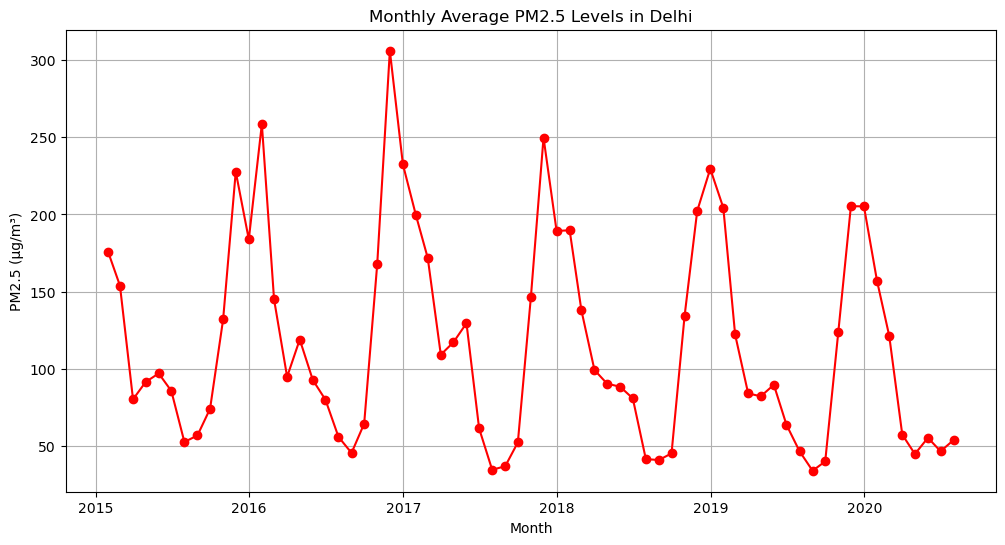

In [19]:
df_monthly = df_daily.resample("M").mean()

plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly, marker='o', color='red')
plt.title("Monthly Average PM2.5 Levels in Delhi")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.show()


C:\Users\kalyani\AppData\Local\Temp\ipykernel_212776\637468447.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_daily.resample("Y").mean()


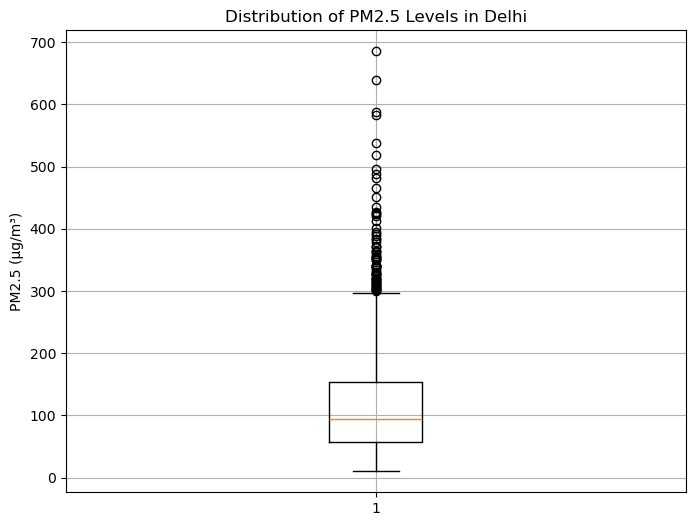

In [20]:
df_yearly = df_daily.resample("Y").mean()

plt.figure(figsize=(8,6))
plt.boxplot(df_daily.dropna(), vert=True)
plt.title("Distribution of PM2.5 Levels in Delhi")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.show()


In [21]:
output = pd.DataFrame({
    "Date": df_daily.index,
    "PM2.5": df_daily.values
})
output.to_excel("Delhi_PM25_Trend.xlsx", index=False)

print("✅ Data exported successfully to Excel!")


✅ Data exported successfully to Excel!


In [22]:
import os
os.getcwd()


'C:\\Users\\kalyani'

In [ ]:
import pandas as pd

df = pd.read_excel("Delhi_PM25_Trend.xlsx")

df.head()


,Date,PM2.5
0,2015-01-01,313.22
1,2015-01-02,186.18
2,2015-01-03,87.18
3,2015-01-04,151.84
4,2015-01-05,146.60


In [24]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.set_index("Date", inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   2009 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


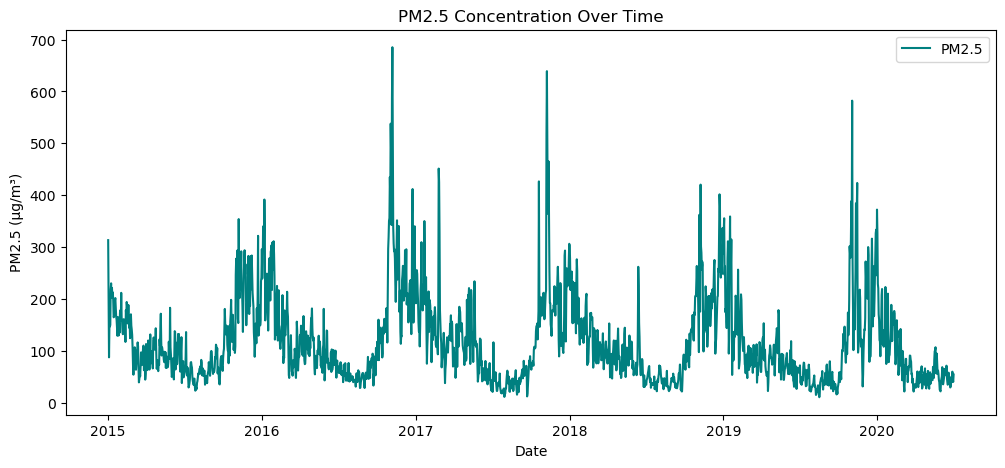

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["PM2.5"], label="PM2.5", color="teal")
plt.title("PM2.5 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df[["PM2.5"]])

scaled_data[:5]


array([[0.44877948],
       [0.26060552],
       [0.11396492],
       [0.20974049],
       [0.20197891]])

In [27]:
import numpy as np

def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_sequences(scaled_data, time_step)


In [ ]:

X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1978, 30, 1)
Shape of y: (1978,)


In [29]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [31]:
!pip install tensorflow


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using c

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) 
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\kalyani\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,         
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0

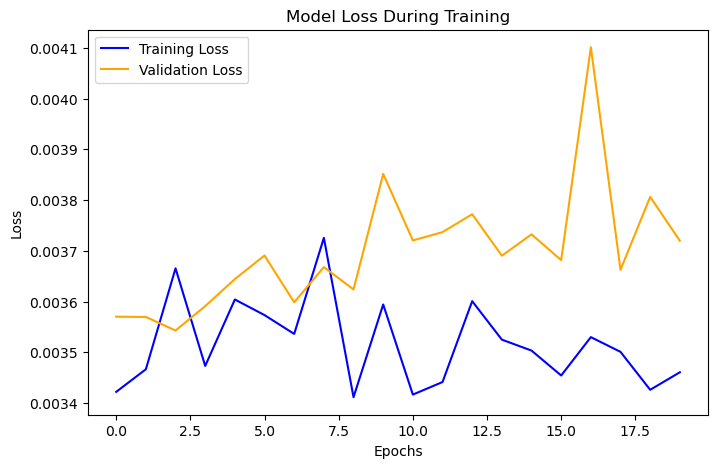

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
